<a href="https://colab.research.google.com/github/C3578/Eval_presentation/blob/master/200926_eval_pres_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import os

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
print(os.getcwd())

/content


In [4]:
data_root = 'gdrive/My Drive/Colab Notebooks/hak_sib/data/'

In [5]:
print(os.listdir(data_root))

['9.JPG', '8.JPG', '12.JPG', '15.JPG', '14.JPG', '16.JPG', '11.JPG', '18.JPG', '10.JPG', '13.JPG', '17.JPG', '7.JPG', '4.JPG', '2.JPG', '6.JPG', '3.JPG', '5.JPG', '1.JPG', 'train_3', 'val_3', 'train', 'cool', 'data', 'test']


In [6]:
import shutil 
from tqdm import tqdm

train_dir = 'data'
val_dir = 'val'

class_names = ['cool', 'not_cool']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'data', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 18/18 [00:07<00:00,  2.43it/s]


In [7]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    #transforms.RandomResizedCrop(224),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 6
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [8]:
len(train_dataloader), len(train_dataset)

(5, 30)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


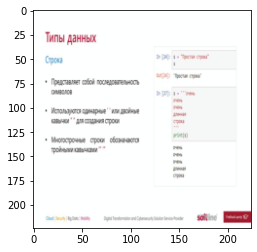

In [9]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean)

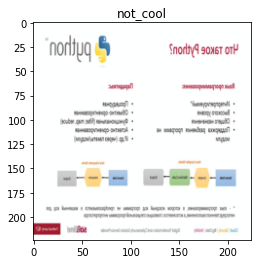

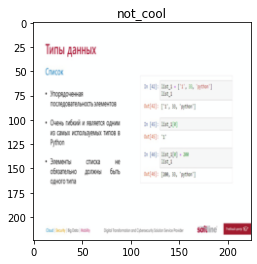

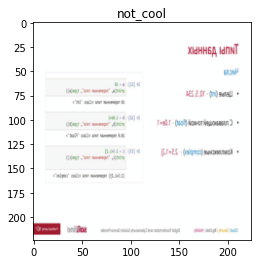

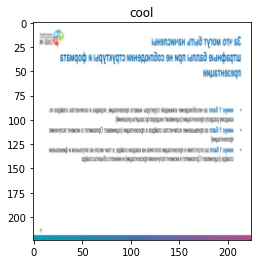

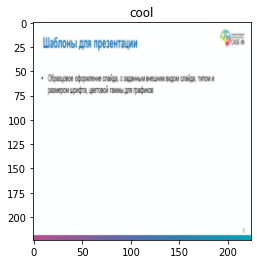

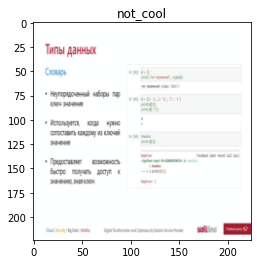

In [10]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [11]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  
            else:
                dataloader = val_dataloader
                model.eval()   

            running_loss = 0.
            running_acc = 0.

            
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [12]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 5)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [13]:
train_model(model, loss, optimizer, scheduler, num_epochs=20); #num_epochs=100

Epoch 0/19:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 5/5 [00:03<00:00,  1.40it/s]

train Loss: 1.0731 Acc: 0.3333



100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

val Loss: 0.7437 Acc: 0.5000
Epoch 1/19:



100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

train Loss: 0.7227 Acc: 0.6000



100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

val Loss: 0.5905 Acc: 0.8333
Epoch 2/19:



100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

train Loss: 0.5410 Acc: 0.7667



100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

val Loss: 0.5018 Acc: 0.8333
Epoch 3/19:



100%|██████████| 5/5 [00:03<00:00,  1.45it/s]

train Loss: 0.4940 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

val Loss: 0.4496 Acc: 0.8333
Epoch 4/19:



100%|██████████| 5/5 [00:03<00:00,  1.47it/s]

train Loss: 0.4794 Acc: 0.7667



100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

val Loss: 0.4283 Acc: 0.8333
Epoch 5/19:



100%|██████████| 5/5 [00:03<00:00,  1.47it/s]

train Loss: 0.3818 Acc: 0.9333



100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

val Loss: 0.4518 Acc: 0.8333
Epoch 6/19:



100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

train Loss: 0.3972 Acc: 0.8667



100%|██████████| 1/1 [00:00<00:00,  1.36it/s]

val Loss: 0.4328 Acc: 0.8333
Epoch 7/19:



100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

train Loss: 0.4233 Acc: 0.9333



100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

val Loss: 0.4092 Acc: 0.8333
Epoch 8/19:



100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

train Loss: 0.3509 Acc: 0.9333



100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

val Loss: 0.4041 Acc: 0.8333
Epoch 9/19:



100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

train Loss: 0.3576 Acc: 0.9667



100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

val Loss: 0.3925 Acc: 0.8333
Epoch 10/19:



100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

train Loss: 0.3582 Acc: 0.9667



100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

val Loss: 0.3856 Acc: 0.8333
Epoch 11/19:



100%|██████████| 5/5 [00:03<00:00,  1.47it/s]

train Loss: 0.3358 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

val Loss: 0.3683 Acc: 0.8333
Epoch 12/19:



100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

train Loss: 0.3294 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  1.33it/s]

val Loss: 0.3683 Acc: 0.8333
Epoch 13/19:



100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

train Loss: 0.3477 Acc: 0.9333



100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

val Loss: 0.3689 Acc: 0.8333
Epoch 14/19:



100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

train Loss: 0.4357 Acc: 0.8333



100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

val Loss: 0.3633 Acc: 0.8333
Epoch 15/19:



100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

train Loss: 0.4150 Acc: 0.8667



100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

val Loss: 0.3732 Acc: 0.8333
Epoch 16/19:



100%|██████████| 5/5 [00:03<00:00,  1.47it/s]

train Loss: 0.3144 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

val Loss: 0.3701 Acc: 0.8333
Epoch 17/19:



100%|██████████| 5/5 [00:03<00:00,  1.46it/s]

train Loss: 0.3142 Acc: 0.9667



100%|██████████| 1/1 [00:00<00:00,  1.35it/s]

val Loss: 0.3602 Acc: 0.8333
Epoch 18/19:



100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

train Loss: 0.3364 Acc: 0.9333



100%|██████████| 1/1 [00:00<00:00,  1.31it/s]

val Loss: 0.3622 Acc: 0.8333
Epoch 19/19:



100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

train Loss: 0.3723 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  1.34it/s]

val Loss: 0.3727 Acc: 0.8333


In [14]:
test_dir = 'test'